## Wine Predictions with NLP

Baby NLP challenge to shake off the cobwebs. Can we predict whether a wine is white or red based on it's description?

Data sourced from: https://www.kaggle.com/datasets/priyamchoksi/global-wine-ratings-dataset?resource=download

In [1]:
#%pip install pandas
#%pip install seaborn
#%pip install scikit-learn
#%pip install nltk

In [35]:
#import packages
import pandas as pd
import numpy as np
#import seaborn as sns #not used in this notebook
from sklearn.linear_model import LogisticRegression
import nltk  
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import word_tokenize   # module for tokenizing strings
import re                                  # library for regular expression operations
import string                              # for string operations
import matplotlib.pyplot as plt

In [36]:
# for lemmatization, you need to download "wordnet" repository which contains family of words
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/nyla033/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load the data

In [37]:
#load in data
#i ended up manually fixing some things to give myself more data hence 'v2'
data = pd.read_csv('/Users/nyla033/Documents/Workspace/Fun_Projects/.venv/wine-ratings-v2.csv') 
data.head()

,name,region,variety,rating,notes
0,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"Mendocino, California",Red Wine,91,"This is a very special, limited release of 100..."
1,1000 Stories Bourbon Barrel Aged Gold Rush Red...,California,Red Wine,89,The California Gold Rush was a period of coura...
2,1000 Stories Bourbon Barrel Aged Gold Rush Red...,California,Red Wine,90,The California Gold Rush was a period of coura...
3,1000 Stories Bourbon Barrel Aged Zinfandel 2013,"North Coast, California",Red Wine,91,"The wine has a deep, rich purple color. An int..."
4,1000 Stories Bourbon Barrel Aged Zinfandel 2014,California,Red Wine,90,Batch #004 is the first release of the 2014 vi...


In [38]:
#only want to keep name, variety, and notes for now
df = data[['variety', 'name', 'notes']]
df

,variety,name,notes
0,Red Wine,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"This is a very special, limited release of 100..."
1,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
2,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
3,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2013,"The wine has a deep, rich purple color. An int..."
4,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2014,Batch #004 is the first release of the 2014 vi...
...,...,...,...
32975,White Wine,Byron Chardonnay 2006,Staying true to the consistent nature of Chard...
32976,White Wine,Booker Vineyard White 2011,The wine starts with honeysuckle and dried pea...
32977,Red Wine,Keenan Napa Valley Cabernet Sauvignon (375ML h...,The 2010 Cabernet Sauvignon is composed primar...
32978,Red Wine,Hearst Ranch Randolph 2015,The 2015 Randolph is a stunning wine as versat...


In [39]:
print(df['variety'].value_counts(normalize=True), 
      df['variety'].value_counts())


variety
Red Wine                 0.722050
White Wine               0.248245
Pink and Rosé            0.015205
Sparkling & Champagne    0.010576
Collectible              0.002299
Green Wine               0.000828
Boutique                 0.000490
Screw Cap                0.000307
Name: proportion, dtype: float64 variety
Red Wine                 23554
White Wine                8098
Pink and Rosé              496
Sparkling & Champagne      345
Collectible                 75
Green Wine                  27
Boutique                    16
Screw Cap                   10
Name: count, dtype: int64


In [40]:
#the data is unbalanced, over 70% red wine. To balance it out we'll take 1/3 of the 'Red Wine' values for our training set, 
#then use the rest of the data (to include pink & rose, etc) as a test set
#also, we'll only take red and white to keep things simple

df_rw = df.loc[(df['variety'] == 'Red Wine') | (df['variety'] == 'White Wine')]
df_rw

,variety,name,notes
0,Red Wine,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"This is a very special, limited release of 100..."
1,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
2,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
3,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2013,"The wine has a deep, rich purple color. An int..."
4,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2014,Batch #004 is the first release of the 2014 vi...
...,...,...,...
32975,White Wine,Byron Chardonnay 2006,Staying true to the consistent nature of Chard...
32976,White Wine,Booker Vineyard White 2011,The wine starts with honeysuckle and dried pea...
32977,Red Wine,Keenan Napa Valley Cabernet Sauvignon (375ML h...,The 2010 Cabernet Sauvignon is composed primar...
32978,Red Wine,Hearst Ranch Randolph 2015,The 2015 Randolph is a stunning wine as versat...


In [41]:
df_rw.isnull().sum()

variety    0
name       0
notes      0
dtype: int64

In [42]:
# there are some blanks cells and some cells with a # + number
# we'll make them NaNs then replace with the name of the wine 
#see if the algorithm can figure out that chardonnay is white
df_rw['notes_new'] = df_rw['notes'].replace(' ', pd.NA).replace('^#d*', pd.NA, regex=True)

/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/681707591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rw['notes_new'] = df_rw['notes'].replace(' ', pd.NA).replace('^#d*', pd.NA, regex=True)


In [43]:
df_rw.isnull().sum()

variety        0
name           0
notes          0
notes_new    533
dtype: int64

In [44]:
[df_rw.loc[pd.isnull(df_rw['notes_new'])]]

[          variety                                               name notes  \
 22       Red Wine    1865 Selected Vineyards Cabernet Sauvignon 2014  #59    
 71     White Wine                             A to Z Chardonnay 2018         
 89       Red Wine                             A to Z Pinot Noir 2011         
 97     White Wine                               A to Z Riesling 2015  #17    
 98     White Wine                               A to Z Riesling 2016   #5    
 ...           ...                                                ...   ...   
 32730    Red Wine              Lewis Cellars Cabernet Sauvignon 2013   #1    
 32758    Red Wine      Lewis Cellars Reserve Cabernet Sauvignon 2010         
 32886  White Wine  Dr. Thanisch Bernkasteler Badstube Kabinett Ri...         
 32928  White Wine                     G.D. Vajra Moscato d'Asti 2015  #73    
 32933  White Wine  Gary Farrell Russian River Selection Chardonna...   #1    
 
       notes_new  
 22         <NA>  
 71         

In [45]:
df_rw.fillna({'notes_new': df_rw['name']}, inplace=True)

/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/3510573785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rw.fillna({'notes_new': df_rw['name']}, inplace=True)


In [46]:
df_rw.isnull().sum()

variety      0
name         0
notes        0
notes_new    0
dtype: int64

In [47]:
#replace notes column with new_notes
df_rw.drop(columns='notes', inplace=True)
df_rw.rename(columns={'notes_new': 'notes'}, inplace=True)

/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/1483730246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rw.drop(columns='notes', inplace=True)
/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/1483730246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rw.rename(columns={'notes_new': 'notes'}, inplace=True)


In [48]:
df_rw

,variety,name,notes
0,Red Wine,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"This is a very special, limited release of 100..."
1,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
2,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
3,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2013,"The wine has a deep, rich purple color. An int..."
4,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2014,Batch #004 is the first release of the 2014 vi...
...,...,...,...
32975,White Wine,Byron Chardonnay 2006,Staying true to the consistent nature of Chard...
32976,White Wine,Booker Vineyard White 2011,The wine starts with honeysuckle and dried pea...
32977,Red Wine,Keenan Napa Valley Cabernet Sauvignon (375ML h...,The 2010 Cabernet Sauvignon is composed primar...
32978,Red Wine,Hearst Ranch Randolph 2015,The 2015 Randolph is a stunning wine as versat...


In [49]:
#the data is unbalanced, over 70% red wine. To balance it out we'll take 20% of the 'Red Wine' values for our training set, 
#also, we'll only take red and white to keep things simple

#select rows where the variety is red wine
df_red = df_rw.loc[df['variety'] == 'Red Wine']
#take a random sample of 20% (~4,710) samples for train & test
df_red_train = df_red.sample(frac=0.2, axis=0, random_state=1)
df_red_test = df_red.sample(frac=0.2, axis=0, random_state=2)
#select rows where the variety is white wine
df_white = df_rw.loc[df['variety'] == 'White Wine']
#take a random sample of half (~4,045) for train & test
df_white_train = df_white.sample(frac=0.5, axis=0, random_state=1)
df_white_test = df_white.sample(frac=0.5, axis=0, random_state=2)
#combine the two dataframes to get a train dataframe
df_train = pd.concat([df_white_train, df_red_train], axis=0)
df_test = pd.concat([df_white_test, df_red_test], axis=0)
#sort by index to shuffle the red/white in the rows
df_train.sort_index(inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_test.sort_index(inplace=True)
df_test.reset_index(inplace=True, drop=True)

In [50]:
df_train.head()

,variety,name,notes
0,Red Wine,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"This is a very special, limited release of 100..."
1,Red Wine,1000 Stories Bourbon Barrel Aged Gold Rush Red...,The California Gold Rush was a period of coura...
2,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2014,Batch #004 is the first release of the 2014 vi...
3,Red Wine,1000 Stories Bourbon Barrel Aged Zinfandel 2017,"Batch 55 embodies an opulent vintage, which sa..."
4,Red Wine,12 Linajes Crianza 2014,Red with violet hues. The aromas are very inte...


### Data cleaning & Pre-processing

Getting the training data ready for pre-processing

In [51]:
#i was debating whether or not to keep the "name" column to provide more words for the model
#decided im going to drop it, if i decide to add it back ill remove the numbers

df_train = df_train[['variety', 'notes']]
df_test = df_test[['variety', 'notes']]

In [52]:
#red wine = 1, white wine = 0
df_train['variety'].replace({'Red Wine': 1, 'White Wine':0}, inplace=True)
df_train

/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/2536508127.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['variety'].replace({'Red Wine': 1, 'White Wine':0}, inplace=True)
/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/2536508127.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no

,variety,notes
0,1,"This is a very special, limited release of 100..."
1,1,The California Gold Rush was a period of coura...
2,1,Batch #004 is the first release of the 2014 vi...
3,1,"Batch 55 embodies an opulent vintage, which sa..."
4,1,Red with violet hues. The aromas are very inte...
...,...,...
8755,1,"Blend: 65% Cabernet Sauvignon, 30% Merlot, 3% ..."
8756,0,One of the more feminine of the chateau's cuve...
8757,1,"""Bright red-ruby. Wild red berries, peony and ..."
8758,1,Every effort is made to make the best wines po...


In [53]:
df_test['variety'].replace({'Red Wine': 1, 'White Wine':0}, inplace=True)

/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/4270806162.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['variety'].replace({'Red Wine': 1, 'White Wine':0}, inplace=True)
/var/folders/q7/jr5cwx7x13v5945__b2lt7tr0000gn/T/ipykernel_85491/4270806162.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_

In [54]:
#adding wine-related words to stopwords
new_stopwords = ['wine', 'vineyard', 'wines', 'vineyards', 'fruit', 'fruits', 'year', 'years', 'grapes', 'grape'] 
#lemmatize would get rid of plurals/variations
stopwords_english = stopwords.words('english')
stopwords_english.extend(new_stopwords) 

In [55]:
stopwords_english

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [56]:
#copied from NLP Coursera process_tweets
def process_notes(note, stopwords_english=stopwords_english):
    '''
    Input:
        note: a string containing a note
    Output:
        notes_clean: a list of words containing the processed note
    '''
    stemmer = PorterStemmer()
    # remove numbers
    note = re.sub(r'\d+','', note)
    # tokenize notes & lowercase
    note_tokens = word_tokenize(note.lower())
    translator = str.maketrans("", "", string.punctuation)

    notes_clean = []
    for word in note_tokens:
        translator = str.maketrans("", "", string.punctuation) # translation table that maps all punctuation characters to None
        word = word.translate(translator) #apply punctuation translator
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            #stem word
            stem_word = stemmer.stem(word)  # stemming word
            notes_clean.append(stem_word)
    return notes_clean

In [57]:
#apply proccess_notes function to the notes in the dataframe
df_train['processed_notes'] = df_train['notes'].apply(lambda x: process_notes(x))
df_train.head()

,variety,notes,processed_notes
0,1,"This is a very special, limited release of 100...","[special, limit, releas, stori, bourbon, barre..."
1,1,The California Gold Rush was a period of coura...,"[california, gold, rush, period, courag, brava..."
2,1,Batch #004 is the first release of the 2014 vi...,"[batch, first, releas, vintag, againmendocino,..."
3,1,"Batch 55 embodies an opulent vintage, which sa...","[batch, embodi, opul, vintag, saw, grow, amid,..."
4,1,Red with violet hues. The aromas are very inte...,"[red, violet, hue, aroma, intens, miner, dairi..."


In [58]:
df_train['notes'][0]

'This is a very special, limited release of 1000 Stories Bourbon Barrel-Aged Carignan, their first-ever release of Carignan as a single varietal. Classic and rustic with a little edge. Look for notes of brilliantly racy red and black fruits set to a rich backdrop of toast, herbs, and cocoa.'

In [59]:
df_train['processed_notes'][0]

['special',
 'limit',
 'releas',
 'stori',
 'bourbon',
 'barrelag',
 'carignan',
 'firstev',
 'releas',
 'carignan',
 'singl',
 'variet',
 'classic',
 'rustic',
 'littl',
 'edg',
 'look',
 'note',
 'brilliantli',
 'raci',
 'red',
 'black',
 'set',
 'rich',
 'backdrop',
 'toast',
 'herb',
 'cocoa']

In [62]:
df_test['processed_notes'] = df_test['notes'].apply(lambda x: process_notes(x))
df_test.head()

,variety,notes,processed_notes
0,1,"On the nose, a complex predominance of mineral...","[nose, complex, predomin, miner, note, backgro..."
1,1,"The 14 Hands Cabernet Sauvignon is a rich, jui...","[hand, cabernet, sauvignon, rich, juici, red, ..."
2,0,This crisp Riesling shows bright flavors of ap...,"[crisp, riesl, show, bright, flavor, appl, pea..."
3,0,This crisp Riesling shows bright flavors of ap...,"[crisp, riesl, show, bright, flavor, appl, pea..."
4,1,"On the front of the palate, you get slow-cooke...","[front, palat, get, slowcook, dark, stone, jam..."


In [63]:
#frequency of words that correlate to red wine (1) vs white wine (0)
#Bag of Words
def build_freqs (notes, label): 
    freqs={}
    for notes, label in zip(notes, label):
        for word in notes:
            pair = (word, label)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [64]:
freqs_train = build_freqs(df_train['processed_notes'], df_train['variety'])
freqs_test = build_freqs(df_test['processed_notes'], df_test['variety'])

In [65]:
freqs_train

{('special', 1): 57,
 ('limit', 1): 34,
 ('releas', 1): 116,
 ('stori', 1): 13,
 ('bourbon', 1): 10,
 ('barrelag', 1): 5,
 ('carignan', 1): 36,
 ('firstev', 1): 1,
 ('singl', 1): 64,
 ('variet', 1): 117,
 ('classic', 1): 244,
 ('rustic', 1): 38,
 ('littl', 1): 59,
 ('edg', 1): 56,
 ('look', 1): 26,
 ('note', 1): 1388,
 ('brilliantli', 1): 3,
 ('raci', 1): 27,
 ('red', 1): 1968,
 ('black', 1): 1679,
 ('set', 1): 38,
 ('rich', 1): 1135,
 ('backdrop', 1): 8,
 ('toast', 1): 205,
 ('herb', 1): 255,
 ('cocoa', 1): 213,
 ('california', 1): 45,
 ('gold', 1): 4,
 ('rush', 1): 5,
 ('period', 1): 21,
 ('courag', 1): 1,
 ('bravado', 1): 2,
 ('curios', 1): 2,
 ('craft', 1): 40,
 ('characterist', 1): 160,
 ('mind', 1): 10,
 ('use', 1): 95,
 ('blend', 1): 676,
 ('bold', 1): 71,
 ('care', 1): 62,
 ('select', 1): 161,
 ('golden', 1): 6,
 ('hill', 1): 115,
 ('valley', 1): 378,
 ('finish', 1): 1600,
 ('barrel', 1): 274,
 ('complement', 1): 113,
 ('char', 1): 16,
 ('vanilla', 1): 566,
 ('dri', 1): 398,
 (

In [66]:
def freqs_df(freq_list):
    '''
    Input: 
        freq_list: frequency list from function build_freqs
    Output: 
        freqs_df: frequency dataframe for visualizations
    '''
    columns = ['Words', 'Frequency']
    freqs_df = pd.DataFrame(list(freq_list.items()), columns=columns)
    freqs_df[['Words', 'Variety']] = pd.DataFrame(freqs_df['Words'].tolist(), index=freqs_df.index)
    freqs_df.sort_values(by='Frequency', ascending=False, inplace=True)
    return freqs_df

In [67]:
#lets see what the frequency dictionary looks like
freq_df_train = freqs_df(freqs_train)
freq_df_test = freqs_df(freqs_test)

freq_df_train

,Words,Frequency,Variety
18,red,1968,1
180,tannin,1967,1
374,aroma,1809,0
122,aroma,1804,1
191,flavor,1741,0
...,...,...,...
9572,denselylay,1,1
9571,paviedecess,1,1
9569,dordogn,1,1
9567,decess,1,1


ratio of weights per class - frequency/red records & white, graph

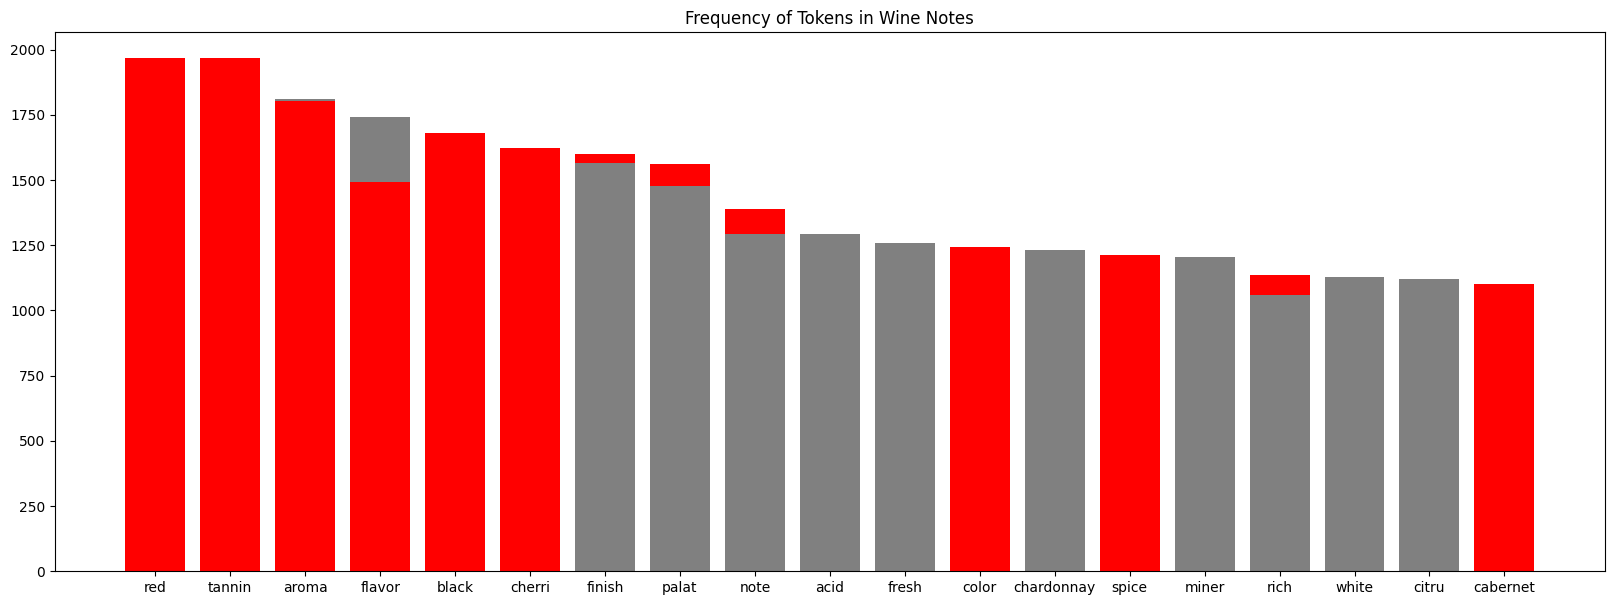

In [68]:
fig, ax = plt.subplots(figsize=(20, 7))
colors = freq_df_train['Variety'].map({1: 'red', 0: 'grey'})

ax.bar(freq_df_train['Words'][:25], freq_df_train['Frequency'][:25], color=colors)
#ax.legend()
plt.title('Frequency of Tokens in Wine Notes')
plt.show()

### Fit & Predict!

In [69]:
def extract_features(note, freqs, process_notes=process_notes):
    '''
    Input: 
        note: a string containing one note
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_notes tokenizes, stems, and removes stopwords
    word_l = process_notes(note)
    
    # 3 elements for [bias, red, white] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
   
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[1] += freqs.get((word, 1), 0)

        # increment the word count for the negative label 0
        x[2] += freqs.get((word, 0), 0)
        
    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

In [71]:
df_train['notes'][0]

'This is a very special, limited release of 1000 Stories Bourbon Barrel-Aged Carignan, their first-ever release of Carignan as a single varietal. Classic and rustic with a little edge. Look for notes of brilliantly racy red and black fruits set to a rich backdrop of toast, herbs, and cocoa.'

In [70]:
tmp1 = extract_features(df_train['notes'][0], freqs_train)
tmp1

array([[1.000e+00, 7.947e+03, 3.801e+03]])

dimensions: bias, count of red, count of white == train model

In [72]:
# collect the features 'x' and stack them into a matrix 'X_train'
#train data
X_train = np.zeros((len(df_train['notes']), 3))
for i in range(len(df_train['notes'])):
    X_train[i, :]= extract_features(df_train['notes'][i], freqs_train)

In [73]:
#test data
X_test = np.zeros((len(df_test['notes']), 3))
for i in range(len(df_test['notes'])):
    X_test[i, :]= extract_features(df_test['notes'][i], freqs_test)

In [74]:
print(X_train.shape, X_test.shape)

(8760, 3) (8760, 3)


In [75]:
#fit logistic regression
y_train = df_train['variety']
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [76]:
#time to predict!
df_test['variety_pred'] = clf.predict(X_test)

In [77]:
df_test.head()

,variety,notes,processed_notes,variety_pred
0,1,"On the nose, a complex predominance of mineral...","[nose, complex, predomin, miner, note, backgro...",1
1,1,"The 14 Hands Cabernet Sauvignon is a rich, jui...","[hand, cabernet, sauvignon, rich, juici, red, ...",1
2,0,This crisp Riesling shows bright flavors of ap...,"[crisp, riesl, show, bright, flavor, appl, pea...",0
3,0,This crisp Riesling shows bright flavors of ap...,"[crisp, riesl, show, bright, flavor, appl, pea...",0
4,1,"On the front of the palate, you get slow-cooke...","[front, palat, get, slowcook, dark, stone, jam...",1


In [78]:
#accuracy is the amount of times (variety = variety pred) / total values
accuracy = len(df_test.loc[df_test['variety']==df_test['variety_pred']])/len(df_test)
print(f'Accuracy is: {accuracy: .2%}')

Accuracy is:  94.82%


In [79]:
y = df_test['variety']
y_pred = df_test['variety_pred']

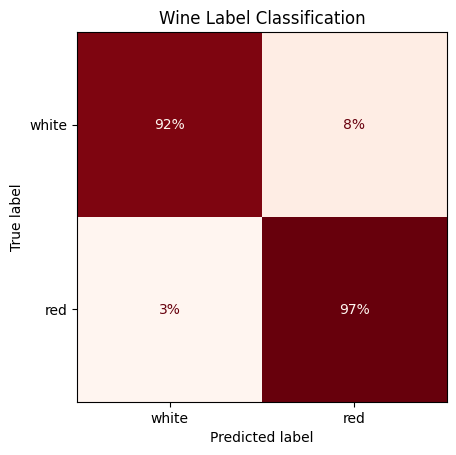

In [80]:
#confusion matrix. 1 is red wine 0 is white wine
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
class_names = {0:'white', 1:'red'}
disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, colorbar=False, cmap='Reds', 
                                               normalize='true', values_format='.0%', display_labels=['white','red'])
title='Wine Label Classification'

disp.ax_.set_title(title)
plt.show()

In [81]:
#what do the incorrectly classified lines look like?
df_miss = df_test[df_test['variety']!= df_test['variety_pred']]
df_miss.reset_index(inplace=True, drop=True)
df_miss.head()

,variety,notes,processed_notes,variety_pred
0,0,Violet and hyacinth aromas make you think of R...,"[violet, hyacinth, aroma, make, think, riesl, ...",1
1,0,The best selection of fruit is comprised in Pr...,"[best, select, compris, praepsositu, kerner]",1
2,0,The origin of the Sylvaner grape can possibly ...,"[origin, sylvan, possibl, trace, back, brought...",1
3,1,Grapes are hand harvested and sorted upon arri...,"[hand, harvest, sort, upon, arriv, wineri, fol...",0
4,1,"Rich, fresh and opulent. Complex and fascinati...","[rich, fresh, opul, complex, fascin, like, old...",0


In [82]:
print(f'{df_miss['notes'][0]}, \n {df_miss['processed_notes'][0]}')

Violet and hyacinth aromas make you think of Riesling (as these wines often do), but the palate is all apples and Rainier cherries with a chalk-powder sprinkle; wonderfully silky and generous, refined and accurate., 
 ['violet', 'hyacinth', 'aroma', 'make', 'think', 'riesl', 'often', 'palat', 'appl', 'rainier', 'cherri', 'chalkpowd', 'sprinkl', 'wonder', 'silki', 'gener', 'refin', 'accur']


In [83]:
#frequency of words mis-classified in variety_pred
freqs_miss = build_freqs(df_miss['processed_notes'], df_test['variety_pred'])

In [84]:
freqs_miss

{('violet', 1): 1,
 ('hyacinth', 1): 1,
 ('aroma', 1): 30,
 ('make', 1): 16,
 ('think', 1): 2,
 ('riesl', 1): 5,
 ('often', 1): 6,
 ('palat', 1): 20,
 ('appl', 1): 3,
 ('rainier', 1): 1,
 ('cherri', 1): 4,
 ('chalkpowd', 1): 1,
 ('sprinkl', 1): 2,
 ('wonder', 1): 8,
 ('silki', 1): 4,
 ('gener', 1): 10,
 ('refin', 1): 6,
 ('accur', 1): 1,
 ('best', 1): 22,
 ('select', 1): 10,
 ('compris', 1): 2,
 ('praepsositu', 1): 1,
 ('kerner', 1): 1,
 ('origin', 0): 7,
 ('sylvan', 0): 1,
 ('possibl', 0): 6,
 ('trace', 0): 3,
 ('back', 0): 2,
 ('brought', 0): 3,
 ('form', 0): 4,
 ('transylvania', 0): 1,
 ('altoadig', 0): 1,
 ('henc', 0): 1,
 ('name', 0): 7,
 ('vine', 0): 23,
 ('also', 0): 12,
 ('said', 0): 1,
 ('germani', 0): 2,
 ('austria', 0): 1,
 ('requir', 0): 2,
 ('perfect', 0): 11,
 ('orient', 0): 1,
 ('climat', 0): 5,
 ('altitud', 0): 2,
 ('produc', 0): 34,
 ('high', 0): 6,
 ('qualiti', 0): 17,
 ('hand', 0): 4,
 ('harvest', 0): 12,
 ('sort', 0): 2,
 ('upon', 0): 2,
 ('arriv', 0): 2,
 ('wineri'

In [85]:
freq_df_miss = freqs_df(freqs_miss)
freq_df_miss

,Words,Frequency,Variety
95,aroma,44,0
188,age,38,1
405,complex,37,0
543,note,37,1
521,vintag,36,1
...,...,...,...
1887,contrast,1,1
1888,autumnwint,1,1
1892,april,1,1
1893,august,1,1


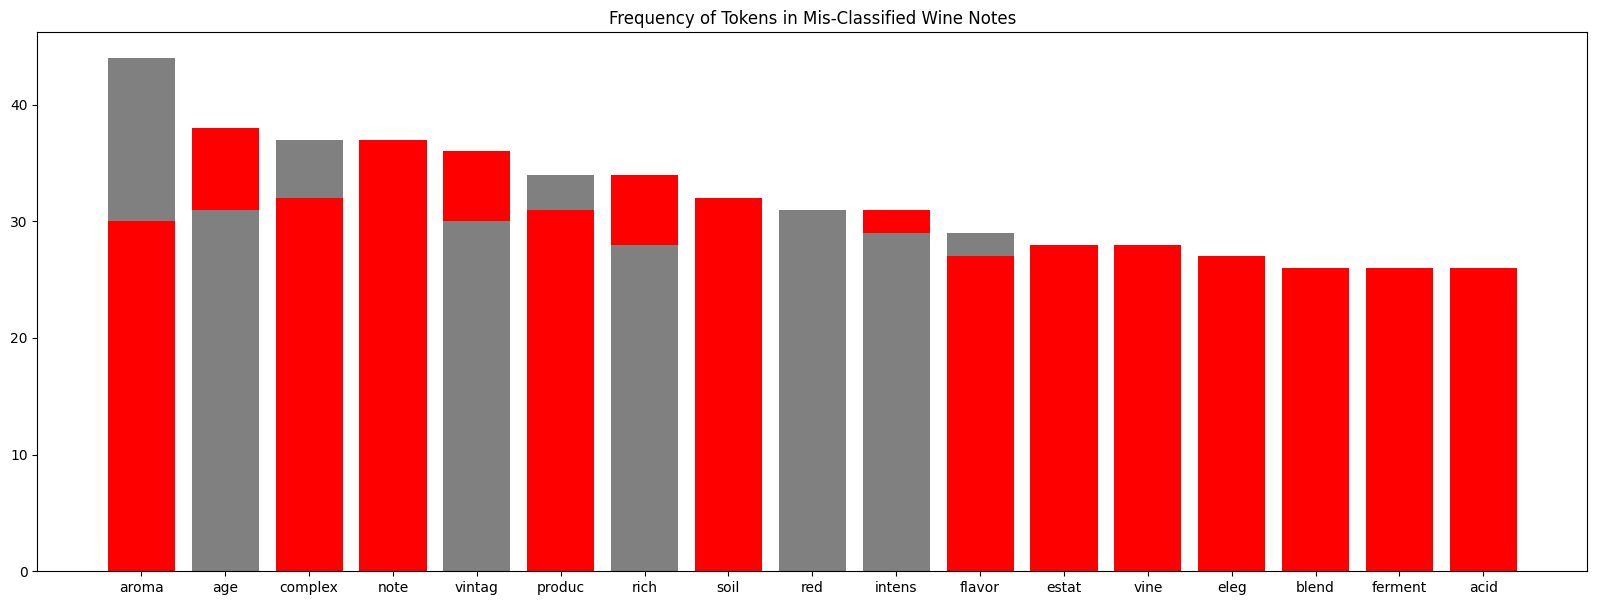

In [86]:
fig, ax = plt.subplots(figsize=(20, 7))
colors = freq_df_miss['Variety'].map({1: 'red', 0: 'grey'})

ax.bar(freq_df_miss['Words'][:25], freq_df_miss ['Frequency'][:25], color=colors)
#ax.legend()
plt.title('Frequency of Tokens in Mis-Classified Wine Notes')
plt.show()

In [87]:
#the model is more likely to predict wine is red vs white. Let's look at those lines
#technically "false positives"
df_miss_FP = df_miss.loc[(df_miss['variety']==0) & (df_miss['variety_pred']==1)]

In [88]:
#miss_FP = build_freqs(df_miss_FP['processed_notes'], df_train['variety'])
miss_FP = build_freqs(df_miss_FP['processed_notes'], df_test['variety_pred'])

In [89]:
freq_df_FP = pd.DataFrame(list(miss_FP.items()), columns=['Words', 'Frequency'])
freq_df_FP[['Words', 'Variety']] = pd.DataFrame(freq_df_FP['Words'].tolist(), index=freq_df_FP.index)
freq_df_FP.sort_values(by='Frequency', ascending=False, inplace=True)
freq_df_FP

,Words,Frequency,Variety
520,complex,32,1
131,age,29,0
65,intens,28,1
167,produc,27,1
275,vintag,26,0
...,...,...,...
1313,novel,1,0
1310,grapevin,1,0
1308,purchas,1,0
1307,ware,1,0


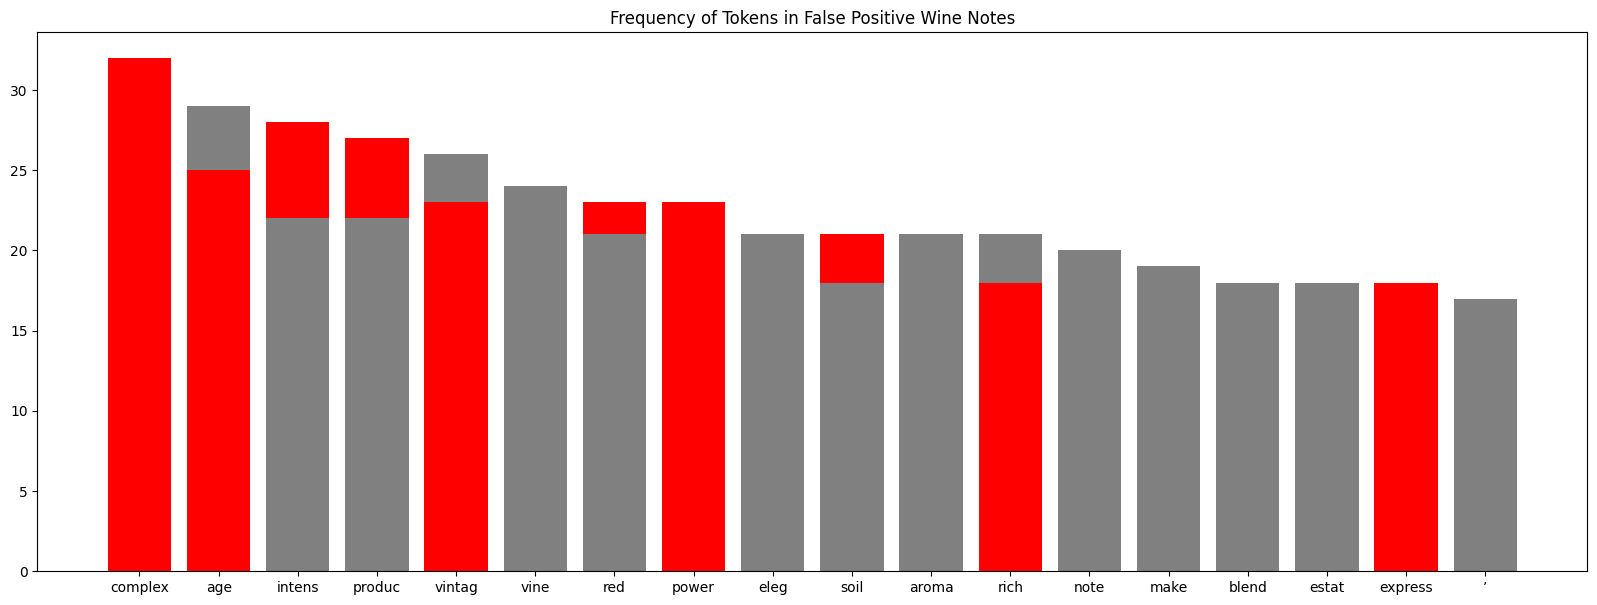

In [90]:
fig, ax = plt.subplots(figsize=(20, 7))
colors = freq_df_FP['Variety'].map({1: 'red', 0: 'grey'})

ax.bar(freq_df_FP['Words'][:25], freq_df_FP ['Frequency'][:25], color=colors)
#ax.legend()
plt.title('Frequency of Tokens in False Positive Wine Notes')
plt.show()

In [91]:
red = df_miss_FP.loc[df_miss_FP['notes'].str.contains(' red ')]
red

,variety,notes,processed_notes,variety_pred
49,0,"Cuvee 61's crisp, fresh feel makes it the idea...","[cuve, crisp, fresh, feel, make, ideal, aperit...",1
93,0,"Intense, complex, persistent bouquet of aprico...","[intens, complex, persist, bouquet, apricot, c...",1
94,0,"Intense, complex, persistent bouquet of aprico...","[intens, complex, persist, bouquet, apricot, c...",1
99,0,This pure Lambrusco di Sorbara wine has led th...,"[pure, lambrusco, di, sorbara, led, way, obtai...",1
117,0,A deep golden robe. Delicate vivacious and lon...,"[deep, golden, robe, delic, vivaci, longlast, ...",1
183,0,Clos Saint Jean produces a total of five diffe...,"[clo, saint, jean, produc, total, five, differ...",1
211,0,Digby Fine English is proud to be the official...,"[digbi, fine, english, proud, offici, sparkl, ...",1
261,0,Style: very fruity and powerful; velvety textu...,"[style, fruiti, power, velveti, textur, ripe, ...",1
265,0,Erdener Pralat (The Bishop of Erdener) combine...,"[erden, pralat, bishop, erden, combin, perfect...",1
266,0,Erdener Pralat (The Bishop of Erdener) combine...,"[erden, pralat, bishop, erden, combin, perfect...",1


In [92]:
red['notes'][261]

'Style: very fruity and powerful; velvety texture; ripe flavors ending on a slight smoky note.  Serving Suggestions: quiche, red meats, mushroom dishes.'

### known issues:
1. The stopwords aren't working (wine, punctuation) -fixed!
2. "Vineyard" needs to be added as a stop-word -fixed! 
3. If the description for a white wine says "good with *red* meats" or "similar to a *red* ... whatever" it will classify as a red wine
3. The frequencies are important but I need to find a way to plot the weight of each word
- This is where TF-IDF could be good, it would likely ignore words like "year" and "grape" 
- So I need to figure out how to implement that...

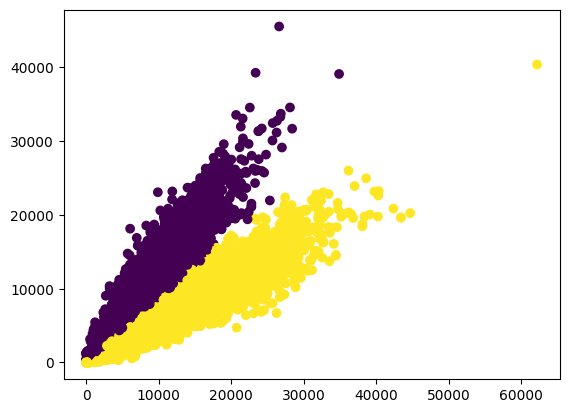

In [50]:
breakpoint
plt.scatter(X_test[:,1],X_test[:,2], c=df_test['variety_pred'])
plt.show()

In [51]:
def freqs_df(freq_list):
    '''
    Input: 
        freq_list: frequency list from function build_freqs
    Output: 
        freqs_df: frequency dataframe for visualizations
    '''
    freqs_df = pd.DataFrame(list(freq_list.items()), columns=['Words', 'Frequency'])
    freqs_df[['Words', 'Variety']] = pd.DataFrame(df['Words'].tolist(), index=freqs_df.index)
    freqs_df.sort_values(by='Frequency', ascending=False, inplace=True)
    return freqs_df

### TF-IDF

Transform corpus with TF-IDF to vectorize the descriptions of wine types

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
#create a corpus by combining all of the processed notes
corpus = df_train['processed_notes'].explode().to_list()

In [54]:
# create object
tfidf = TfidfVectorizer()
 
# get tf-df values
result = tfidf.fit_transform(corpus)

AttributeError: 'float' object has no attribute 'lower'